In [1]:
import pandas

df = pandas.read_csv("./opensearch_results_merged.csv", low_memory=False)
print(df.shape)
print(df.columns)
print(df.head())
print(df.info())
df.describe()
df.nunique()
print(df.duplicated())
df=df.drop_duplicates()
df=df.dropna(thresh=5)



(306813, 376)
Index(['agent.id', 'agent.name', 'agent.ip', 'data.alert_type', 'data.app',
       'data.arch', 'data.audit.auid', 'data.audit.id', 'data.audit.pid',
       'data.audit.res',
       ...
       'data.winCounter.DefaultScale', 'data.winCounter.InstanceName',
       'data.winCounter.MultipleCount', 'data.winCounter.Path',
       'data.winCounter.RawValue', 'data.winCounter.SecondValue',
       'data.winCounter.Status', 'data.winCounter.TimeBase',
       'data.winCounter.Timestamp', 'data.winCounter.Timestamp100NSec'],
      dtype='object', length=376)
   agent.id      agent.name agent.ip data.alert_type data.app data.arch  \
0         0  vm33-isobuild3      NaN             NaN      NaN       NaN   
1         0  vm33-isobuild3      NaN             NaN      NaN       NaN   
2         0  vm33-isobuild3      NaN             NaN      NaN       NaN   
3         0  vm33-isobuild3      NaN             NaN      NaN       NaN   
4         0   stage-manager      NaN             NaN    

In [2]:
print("[*] Shape after cleaning:", df.shape)

print("Dropped rows (%):", (1 - len(df)/306813) * 100)


[*] Shape after cleaning: (134234, 376)
Dropped rows (%): 56.24892035213631


In [3]:
missing_ratio = df.isna().mean().sort_values(ascending=False)
print(missing_ratio.head(376)) 

data.level                             1.000000
data.win.eventdata.supportInfo2        0.999993
data.win.eventdata.param5              0.999993
data.win.eventdata.errorDescription    0.999993
data.win.uMDFHostProblem.lifetimeId    0.999993
                                         ...   
data.win.system.computer               0.344235
data.win.system.channel                0.344235
agent.ip                               0.003442
agent.name                             0.000000
agent.id                               0.000000
Length: 376, dtype: float64


In [4]:
unique_counts = df.nunique().sort_values()
print(unique_counts.head(100))   
print(unique_counts.tail(100))   

data.level                                  0
data.win.eventdata.errorDescription         1
data.win.uMDFHostProblem.detectedBy         1
data.vulnerability.type                     1
data.win.uMDFHostProblem.activeOperation    1
                                           ..
data.protocol                               1
data.eventdata.ruleName                     1
data.winCounter.InstanceName                1
data.eventdata.terminalSessionId            1
data.eventdata.user                         1
Length: 100, dtype: int64
data.vulnerability.cvss.cvss2.base_score       12
data.win.eventdata.subjectUserSid              13
data.win.eventdata.originalFileName            13
data.win.eventdata.terminalSessionId           13
data.sca.failed                                14
                                            ...  
data.ram                                    35206
data.win.eventdata.utcTime                  44539
data.win.system.message                     84210
data.win.system.ev

In [5]:
drop_missing = missing_ratio[missing_ratio > 0.95].index.tolist()
df_reduced = df.drop(columns=drop_missing)

constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_cols)
print(f"Dropped {len(constant_cols)} constant columns")

unique_counts = df_reduced.nunique()
drop_unique = unique_counts[unique_counts <=1 ].index.tolist()
df_reduced = df_reduced.drop(columns=drop_unique)

print("[*] Reduced dataset shape:",df_reduced.shape)


Dropped 126 constant columns
[*] Reduced dataset shape: (134234, 56)


In [6]:
empty_rows = df_reduced[df_reduced.isna().any(axis=1)]
print(len(empty_rows))
df_reduced = df_reduced.dropna(how='all')

dup_count = df_reduced.duplicated().sum()
print(dup_count)

df_reduced = df_reduced.drop_duplicates()

threshold=0.9 #if 90% columns of the rows are NaN
row_missing_ratio = df_reduced.isna().mean(axis=1)
df_reduced = df_reduced[row_missing_ratio < threshold]


134234
4928


In [7]:
non_missing_ratio = 1 - df_reduced.isna().mean()
print(non_missing_ratio.sort_values(ascending=False).head(20))

non_null_counts = df.notna().sum(axis=1)
threshold = 20   # number of non-null values to consider a row 'dense'

dense_rows = df[non_null_counts >= threshold]
sparse_rows = df[non_null_counts < threshold]

print(f"[*] Dense rows (>= {threshold} non-null values): {len(dense_rows)}")
print(f"[*] Sparse rows (< {threshold} non-null values): {len(sparse_rows)}")


agent.id                         1.000000
agent.name                       1.000000
agent.ip                         0.999940
data.win.system.threadID         0.887010
data.win.system.task             0.887010
data.win.system.systemTime       0.887010
data.win.system.severityValue    0.887010
data.win.system.providerName     0.887010
data.win.system.processID        0.887010
data.win.system.opcode           0.887010
data.win.system.level            0.887010
data.win.system.keywords         0.887010
data.win.system.eventRecordID    0.887010
data.win.system.eventID          0.887010
data.win.system.computer         0.887010
data.win.system.channel          0.887010
data.win.system.version          0.887010
data.win.system.message          0.886748
data.win.system.providerGuid     0.862776
data.win.eventdata.processId     0.655488
dtype: float64
[*] Dense rows (>= 20 non-null values): 85975
[*] Sparse rows (< 20 non-null values): 48259


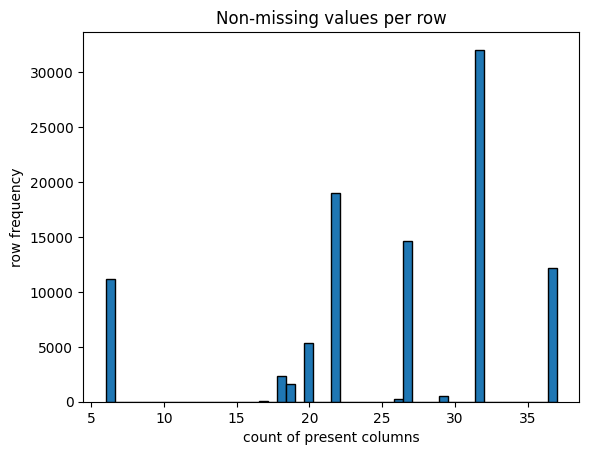

In [8]:
import matplotlib.pyplot as plt

raw_non_missing = df_reduced.notna().sum(axis=1)
plt.hist(raw_non_missing, bins=50, edgecolor="k")
plt.title("Non-missing values per row")
plt.xlabel("count of present columns")
plt.ylabel("row frequency")
plt.show()

In [9]:
df.to_csv("opensearch_reduced.csv", index=False)
dense_rows.to_csv("opensearch_dense.csv", index=False)
sparse_rows.to_csv("opensearch_sparse.csv", index=False)

print("[+] Cleaned dataset saved:")
print("    - opensearch_reduced.csv (all cleaned data)")
print("    - opensearch_dense.csv   (rows with enough information)")
print("    - opensearch_sparse.csv  (rows with little information)")

df.head()

[+] Cleaned dataset saved:
    - opensearch_reduced.csv (all cleaned data)
    - opensearch_dense.csv   (rows with enough information)
    - opensearch_sparse.csv  (rows with little information)


,agent.id,agent.name,agent.ip,data.alert_type,data.app,data.arch,data.checksum,data.cpu,data.dpkg_status,data.file,...,data.win.umdfDeviceOffline.instanceId,data.win.umdfDeviceOffline.lifetimeId,data.win.umdfDeviceOffline.location,data.win.umdfDeviceOffline.restartCount,data.winCounter.CookedValue,data.winCounter.Path,data.winCounter.RawValue,data.winCounter.SecondValue,data.winCounter.Timestamp,data.winCounter.Timestamp100NSec
8,0,stage-manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0,stage-manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,0,stage-manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,0,stage-manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,0,stage-manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
